# Model Building

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_actual_vs_prediction, plot_residual
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv('malang_clean.csv')
df.head()

,price,bedroom,hsize,lsize,location_bin
0,320.0,2.0,36.0,72.0,Kedungkandang
1,600.0,3.0,70.0,64.0,other
2,459.0,3.0,65.0,60.0,other
3,227.0,2.0,62.0,43.0,other
4,250.0,2.0,50.0,84.0,other


In [3]:
df.columns

Index(['price', 'bedroom', 'hsize', 'lsize', 'location_bin'], dtype='object')

In [4]:
df.dropna(inplace=True)

In [5]:
df.isnull().sum()

price           0
bedroom         0
hsize           0
lsize           0
location_bin    0
dtype: int64

## Dataset Spliting

In [6]:
X = df.drop(columns='price')
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2082, 4), (521, 4), (2082,), (521,))

## XGBoost

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [8]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['bedroom', 'hsize', 'lsize']),
    ('categoric', cat_pipe(encoder='onehot'), ['location_bin']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='neg_mean_absolute_error', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.0s finished


{'algo__colsample_bytree': 0.8284250399306623, 'algo__gamma': 3, 'algo__learning_rate': 0.03253972566577117, 'algo__max_depth': 8, 'algo__n_estimators': 112, 'algo__reg_alpha': 0.002120199469953843, 'algo__reg_lambda': 0.0010489129591818502, 'algo__subsample': 0.6139472074743181}
-183.2196604947091 -331.07273314935685 -297.9457363131561


### Evaluation

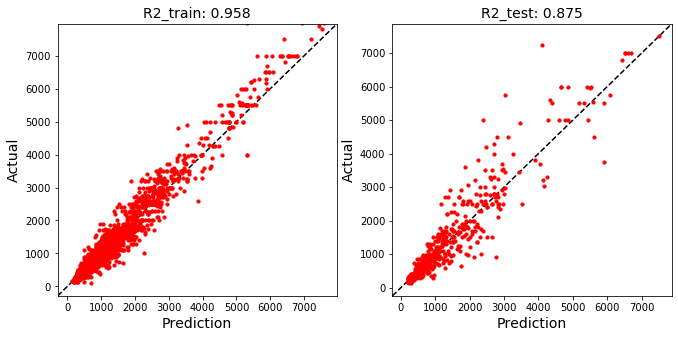

In [9]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

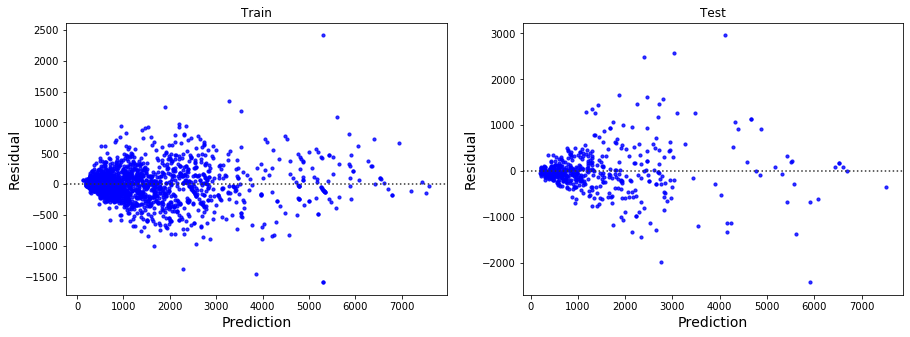

In [10]:
plot_residual(X_train, y_train, X_test, y_test, model)

## ElasticNet

In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [28]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['bedroom', 'hsize', 'lsize']),
    ('categoric', cat_pipe(encoder='onehot'), ['location_bin']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(pipeline, rsp.enet_params, cv=3, scoring='neg_mean_absolute_error', n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s


{'algo__alpha': 0.02925648048608761, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.2786464642366115}
-354.39984986366466 -358.3422760951241 -361.062768623342


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.0s finished


### Evaluation

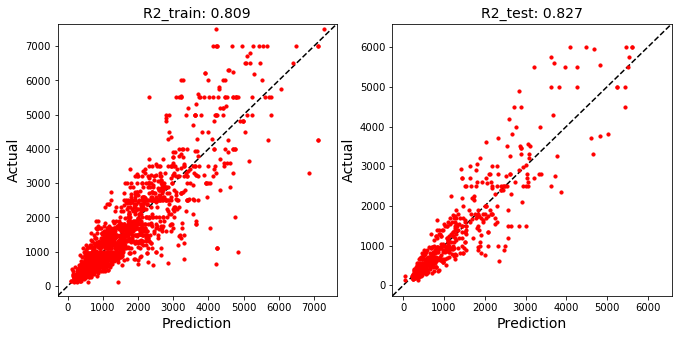

In [29]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

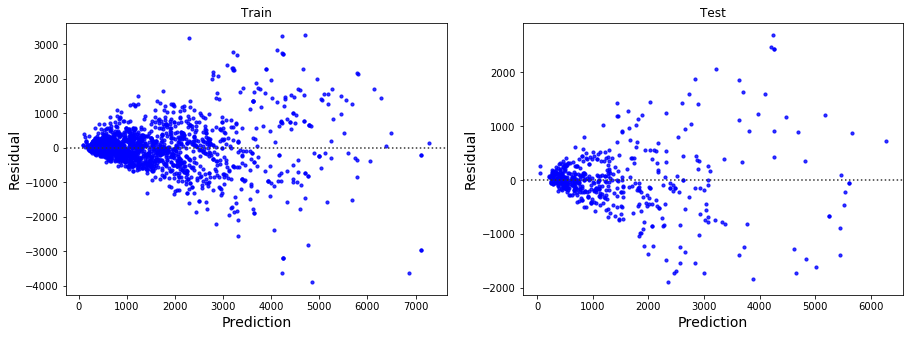

In [30]:
plot_residual(X_train, y_train, X_test, y_test, model)

### Feature Importance

,feature,importance,stdev
2,lsize,429.084207,5.009313
1,hsize,279.228683,8.051285
3,location_bin,9.088680,1.107295
0,bedroom,5.607260,0.596131


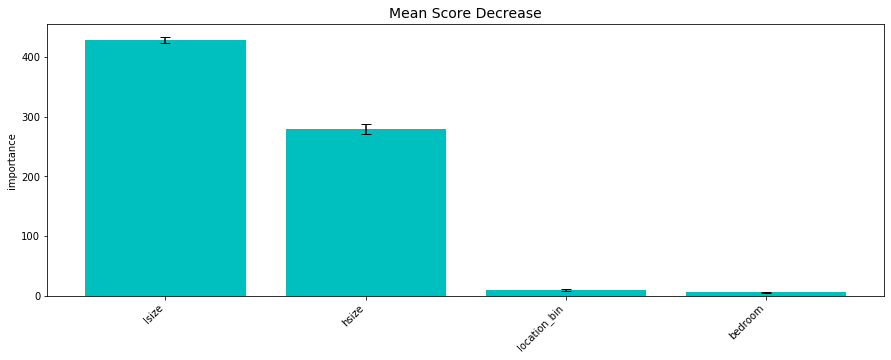

In [31]:
mean_score_decrease(X_train, y_train, model, plot=True)

# Conclusion

- XGBoost have a train accuracy of 95% but the test score is 87%, the model is considered overfit.
- Elastic Net in the other hand perform really great without overfitting to the train data with accuracy of 80% on the training, and 83% on the test.
- Elasic Net test accuracy is better than train accuracy indicating it's in fact a good model.
- Our residual plot show us that our model not really perform well with price larger than Rp. 2.000.000.000
- We need more data to train our model, especially data with price more than Rp. 2.000.000.000
- Using only 4 features we accomplished a great test accuracy of 82% and MAE 350-360
- From our 4 features, lsize(lot size) and hsize(house size) is important to predict the house price.
- We can still improve our model with more features and more data.